In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
import numpy as np

# Downloading Stories

In [11]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'
dir_name = 'data'
def download_data(url, filename, download_dir):
    """Download a file if not present, and make sure it's the right
    size."""
    # Create directories if doesn't exist
    os.makedirs(download_dir, exist_ok=True)
    # If file doesn't exist download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)
    return filepath
# Number of files and their names to download
num_files = 209
filenames = [format(i, '03d')+'.txt' for i in range(1,num_files+1)]
# Download each file
for fn in filenames:
    download_data(url, fn, dir_name)
# Check if all files are downloaded
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name,filenames[i]))
    assert file_exists
print('{} files found.'.format(len(filenames)))

209 files found.


# Split train, validation and test data

In [12]:
import os
from sklearn.model_selection import train_test_split

# Fix the random seed so we get the same output every time
random_state = 54321

# Define the directory name
dir_name = 'data'

# Get a list of valid filenames in the 'data' folder
filenames = [
    os.path.join(dir_name, f) 
    for f in os.listdir(dir_name) 
    if f.endswith('.txt') and f[:-4].isdigit() and 1 <= int(f[:-4]) <= 209
]

# First separate train and valid+test data
train_filenames, test_and_valid_filenames = train_test_split(filenames, test_size=0.2, random_state=random_state)

# Separate valid+test data to validation and test data
valid_filenames, test_filenames = train_test_split(test_and_valid_filenames, test_size=0.5, random_state=random_state)

# Print out the sizes and some sample filenames
for subset_id, subset in zip(('train', 'valid', 'test'), (train_filenames, valid_filenames, test_filenames)):
    print(f"Got {len(subset)} files in the {subset_id} dataset (e.g. {subset[:3]})")

Got 167 files in the train dataset (e.g. ['data/148.txt', 'data/198.txt', 'data/032.txt'])
Got 21 files in the valid dataset (e.g. ['data/055.txt', 'data/078.txt', 'data/087.txt'])
Got 21 files in the test dataset (e.g. ['data/056.txt', 'data/101.txt', 'data/114.txt'])


# Find the vocabulary size

In [13]:
bigram_set = set()

# Go through each file in the training set
for fname in train_filenames:
    document = [] # This will hold all the text
    with open(fname, 'r') as f:
        for row in f:
            # Convert text to lower case to reduce input dimensionality
            document.append(row.lower())

        # From the list of text we have, generate one long string (containing all training stories)
        document = " ".join(document)

        # Update the set with all bigrams found
        bigram_set.update([document[i:i+2] for i in range(0, len(document), 2)])

# Assign to a variable and print
n_vocab = len(bigram_set)
print(f"Found {n_vocab} unique bigrams")

Found 700 unique bigrams


# Reading data and generate batches for the model (tf.data API)

In [14]:
def generate_tf_dataset(filenames, ngram_width, window_size, batch_size, shuffle=False):
    """ Generate batched data from a list of files speficied """

    # Read the data found in the documents
    documents = []
    for f in filenames:
        doc = tf.io.read_file(f)
        doc = tf.strings.ngrams(    # Generate ngrams from the string
            tf.strings.bytes_split(    # Create a list of chars from a string
                tf.strings.regex_replace(    # Replace new lines with space
                    tf.strings.lower(    # Convert string to lower case
                        doc
                    ), "\n", " "
                )
            ),
            ngram_width, separator=''
        )
        documents.append(doc.numpy().tolist())

    # documents is a list of list of strings, where each string is a story
    # From that we generate a ragged tensor
    documents = tf.ragged.constant(documents)
    # Create a dataset where each row in the ragged tensor would be a sample
    doc_dataset = tf.data.Dataset.from_tensor_slices(documents)
    # We need to perform a quick transformation - tf.strings.ngrams would generate
    # all the ngrams (e.g. abcd -> ab, bc, cd) with overlap, however for our data
    # we do not need the overlap, so we need to skip the overlapping ngrams
    # the following line does that
    doc_dataset = doc_dataset.map(lambda x: x[::ngram_width])

    # Here we are using a window function to generate windows from text
    # For a text sequence with window_size 3 and shift 1 you get
    # e.g. ab, cd, ef, gh, ij, ... -> [ab, cd, ef], [cd, ef, gh], [ef, gh, ij], ...
    # each of these windows is a single training sequence for our model
    doc_dataset = doc_dataset.flat_map(
        lambda x: tf.data.Dataset.from_tensor_slices(
            x
        ).window(
            size=window_size+1, shift=int(window_size * 0.75)
        ).flat_map(
            lambda window: window.batch(window_size+1, drop_remainder=True)
        )
    )

    # From each windowed sequence we generate input and target tuple
    # e.g. [ab, cd, ef] -> ([ab, cd], [cd, ef])
    doc_dataset = doc_dataset.map(lambda x: (x[:-1], x[1:]))

    # Shuffle the data if required
    doc_dataset = doc_dataset.shuffle(buffer_size=batch_size*10) if shuffle else doc_dataset

    # Batch the data
    doc_dataset = doc_dataset.batch(batch_size=batch_size)

    # Return the data
    return doc_dataset


ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)
test_ds = generate_tf_dataset(test_filenames, ngram_length, window_size, batch_size)

# Generate few samples from the dataset function

In [15]:
ds = generate_tf_dataset(train_filenames, 2, window_size=10, batch_size=1).take(5)

for record in ds:
    print(record[0].numpy(), '->', record[1].numpy())

[[b'on' b'e ' b'af' b'te' b'rn' b'oo' b'n ' b'th' b'e ' b'ch']] -> [[b'e ' b'af' b'te' b'rn' b'oo' b'n ' b'th' b'e ' b'ch' b'ri']]
[[b'th' b'e ' b'ch' b'ri' b'st' b'-c' b'hi' b'ld' b' h' b'ad']] -> [[b'e ' b'ch' b'ri' b'st' b'-c' b'hi' b'ld' b' h' b'ad' b' l']]
[[b'ld' b' h' b'ad' b' l' b'ai' b'd ' b'hi' b'ms' b'el' b'f ']] -> [[b' h' b'ad' b' l' b'ai' b'd ' b'hi' b'ms' b'el' b'f ' b'in']]
[[b'ms' b'el' b'f ' b'in' b' h' b'is' b' c' b'ra' b'dl' b'e-']] -> [[b'el' b'f ' b'in' b' h' b'is' b' c' b'ra' b'dl' b'e-' b'be']]
[[b'ra' b'dl' b'e-' b'be' b'd ' b'an' b'd ' b'ha' b'd ' b'fa']] -> [[b'dl' b'e-' b'be' b'd ' b'an' b'd ' b'ha' b'd ' b'fa' b'll']]


# Defining the model

In [16]:
import tensorflow.keras.backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()

# Defining a TextVectorization layer

In [17]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/layers/preprocessing/text_vectorization.py:340: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


In [18]:
# Print a few bigrams learnt by the vectorization layer
text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'e ', 'he', ' t', 'th', 'd ', ' a', ', ', ' h']

# Convert the targets from string ngrams to ngram IDs


In [19]:
train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))
test_ds = test_ds.map(lambda x, y: (x, text_vectorizer(y)))

# Language model

In [20]:
lm_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.LSTM(512, return_sequences=True),
    layers.LSTM(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

# Metrics and compilation

In [21]:
# Inspired by https://gist.github.com/Gregorgeous/dbad1ec22efc250c76354d949a13cec3
class PerplexityMetric(tf.keras.metrics.Mean):

    def __init__(self, name='perplexity', **kwargs):
      super().__init__(name=name, **kwargs)
      self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

    def _calculate_perplexity(self, real, pred):

      # The next 4 lines zero-out the padding from loss calculations,
      # this follows the logic from: https://www.tensorflow.org/beta/tutorials/text/transformer#loss_and_metrics
      loss_ = self.cross_entropy(real, pred)

      # Calculating the perplexity steps:
      step1 = K.mean(loss_, axis=-1)
      perplexity = K.exp(step1)

      return perplexity

    def update_state(self, y_true, y_pred, sample_weight=None):
      perplexity = self._calculate_perplexity(y_true, y_pred)
      # Remember self.perplexity is a tensor (tf.Variable), so using simply "self.perplexity = perplexity" will result in error because of mixing EagerTensor and Graph operations
      super().update_state(perplexity)


In [22]:
lm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

In [23]:
lstm_history = lm_model.fit(train_ds, validation_data=valid_ds, epochs=5)

Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node sequential_1/Cast defined at (most recent call last):
  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/runpy.py", line 87, in _run_code

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_2371/2723294643.py", line 1, in <module>

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/models/sequential.py", line 212, in call

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/models/functional.py", line 167, in call

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/models/functional.py", line 258, in _standardize_inputs

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/models/functional.py", line 218, in _convert_inputs_to_tensors

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/ops/core.py", line 822, in convert_to_tensor

  File "/workspaces/Deep-Learning-Natural-Language-Processing/.conda/lib/python3.9/site-packages/keras/src/backend/tensorflow/core.py", line 132, in convert_to_tensor

Cast string to float is not supported
	 [[{{node sequential_1/Cast}}]] [Op:__inference_one_step_on_iterator_84536]

In [ ]:
lm_model.evaluate(test_ds)

# Inference model
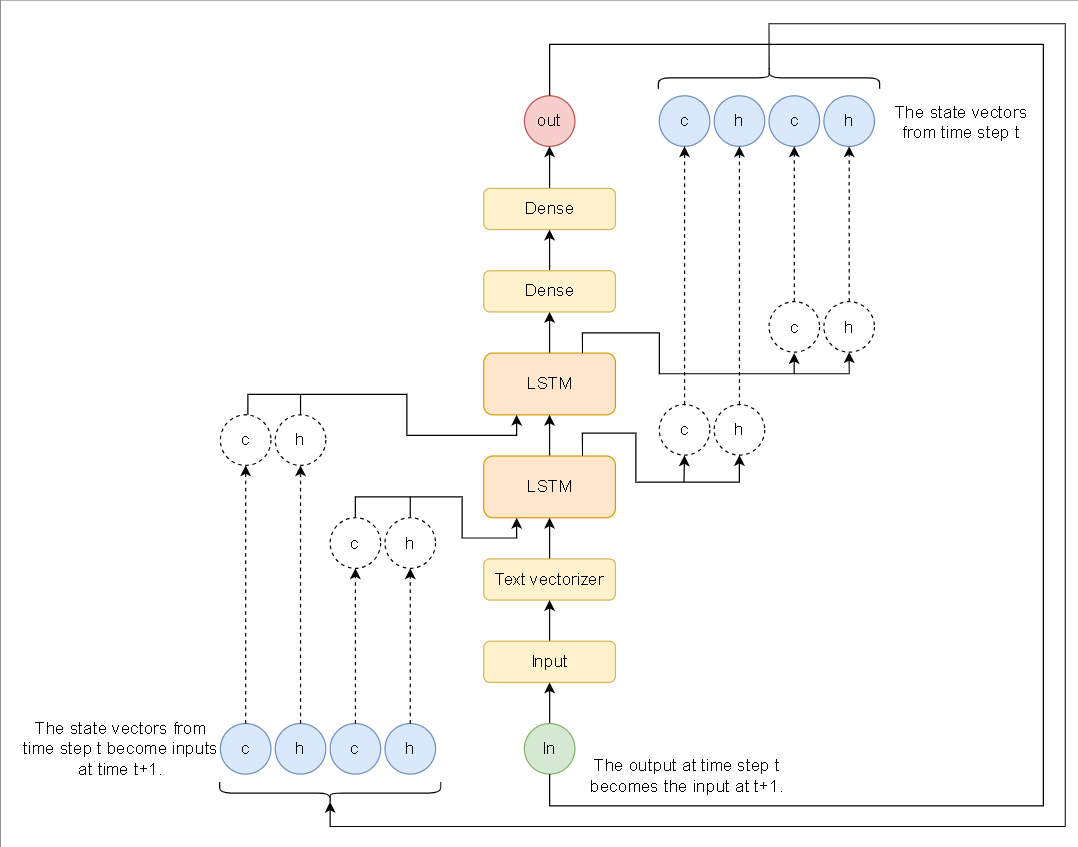

In [ ]:
# Define inputs to the model
inp = tf.keras.layers.Input(dtype=tf.string, shape=(1,))

text_vectorized_out = lm_model.get_layer('text_vectorization')(inp)

inp_state_c_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_h_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_c_lstm_1 = tf.keras.layers.Input(shape=(256,))
inp_state_h_lstm_1 = tf.keras.layers.Input(shape=(256,))

# Define embedding layer and output
emb_layer = lm_model.get_layer('embedding')
emb_out = emb_layer(text_vectorized_out)

# Defining a LSTM layers and output
lstm_layer = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True)
lstm_out, lstm_state_c, lstm_state_h = lstm_layer(emb_out, initial_state=[inp_state_c_lstm, inp_state_h_lstm])

lstm_1_layer = tf.keras.layers.LSTM(256, return_state=True, return_sequences=True)
lstm_1_out, lstm_1_state_c, lstm_1_state_h = lstm_1_layer(lstm_out, initial_state=[inp_state_c_lstm_1, inp_state_h_lstm_1])

# Defining a Dense layer and output
dense_out = lm_model.get_layer('dense')(lstm_1_out)

# Defining the final Dense layer and output
final_out = lm_model.get_layer('dense_1')(dense_out)
#softmax_out = tf.keras.layers.Activation(activation='softmax')(final_out)

# Copy the weights from the original model
lstm_layer.set_weights(lm_model.get_layer('lstm').get_weights())
lstm_1_layer.set_weights(lm_model.get_layer('lstm_1').get_weights())

# Define final model
infer_model = tf.keras.models.Model(
    inputs=[inp, inp_state_c_lstm, inp_state_h_lstm, inp_state_c_lstm_1, inp_state_h_lstm_1],
    outputs=[final_out, lstm_state_c, lstm_state_h, lstm_1_state_c, lstm_1_state_h])

# LSTM with Beam-Search

In [ ]:
def beam_one_step(model, input_, states):
    """ Perform the model update and output for one step"""
    out = model.predict([input_, *states])
    output, new_states = out[0], out[1:]
    return output, new_states


def beam_search(model, input_, states, beam_depth=5, beam_width=3):
    """ Defines an outer wrapper for the computational function of beam search """

    vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
    index_word = dict(zip(range(len(vocabulary)), vocabulary))

    def recursive_fn(input_, states, sequence, log_prob, i):
        """ This function performs actual recursive computation of the long string"""

        if i == beam_depth:
            """ Base case: Terminate the beam search """
            results.append((list(sequence), states, np.exp(log_prob)))
            return sequence, log_prob, states
        else:
            """ Recursive case: Keep computing the output using the previous outputs"""
            output, new_states = beam_one_step(model, input_, states)

            # Get the top beam_widht candidates for the given depth
            top_probs, top_ids = tf.nn.top_k(output, k=beam_width)
            top_probs, top_ids = top_probs.numpy().ravel(), top_ids.numpy().ravel()

            # For each candidate compute the next prediction
            for p, wid in zip(top_probs, top_ids):
                new_log_prob = log_prob + np.log(p)

                # we are going to penalize joint probability whenever the same symbol is repeating
                if len(sequence)>0 and wid == sequence[-1]:
                    new_log_prob = new_log_prob + np.log(1e-1)

                sequence.append(wid)
                _ = recursive_fn(np.array([[index_word[wid]]]), new_states, sequence, new_log_prob, i+1)
                sequence.pop()


    results = []
    sequence = []
    log_prob = 0.0
    recursive_fn(input_, states, sequence, log_prob, 0)

    results = sorted(results, key=lambda x: x[2], reverse=True)

    return results

In [ ]:
text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))


seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print(f"Making {len(seq)} predictions from input")


# Reset the state of the model initially
lm_model.reset_states()

# Definin the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

states = [state_c, state_h, state_c_1, state_h_1]

# Recursively update the model by assining new state to state
for c in seq:
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

# Predict for 100 time steps
for i in range(50):
    print('.', end='')

    # Get the results from beam search
    result = beam_search(infer_model, x, states, 5, 5)

    # Get one of the top 10 results based on their likelihood
    n_probs = np.array([p for _,_,p in result[:10]])
    p_j = np.random.choice(list(range(n_probs.size)), p=n_probs/n_probs.sum())
    best_beam_ids, states, _ = result[p_j]
    x = np.array([[index_word[best_beam_ids[-1]]]])

    text.extend([index_word[w] for w in best_beam_ids])

print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))